<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML2/blob/main/RandomForest/SML2010_Selection_Variables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd

import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor

from keras import backend as K

# Chargement et correction des données

Ce dataset est utilisé pour effectuer la prédiction de la température d'une pièce en fonction de plusieurs paramètres mesurés. La fréquence originale des données est d'une minute, puis a été modifiée à 15minutes avec un filtrage. L'ensemble correspond environ à une durée de 40 jours.  
Nous allons utiliser ici la température de la chambre comme cible et sélectionner 18 séries exogènes. 

**1. Chargement des données**

In [ ]:
!rm *.txt
!curl --location --remote-header-name --remote-name "https://github.com/AlexandreBourrieau/FICHIERS/raw/main/Series_Temporelles/Multi/Data/NEW-DATA-1.T15.txt"

rm: cannot remove '*.txt': No such file or directory
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   181  100   181    0     0    624      0 --:--:-- --:--:-- --:--:--   624
100  386k  100  386k    0     0   777k      0 --:--:-- --:--:-- --:--:--  777k


**2. Analyse et correction des données**

In [ ]:
# Création de la série sous Pandas
df_etude = pd.read_csv("NEW-DATA-1.T15.txt",sep=" ")
df_etude

,Date,Time,Temperature_Comedor_Sensor,4:Temperature_Habitacion_Sensor,5:Weather_Temperature,6:CO2_Comedor_Sensor,7:CO2_Habitacion_Sensor,8:Humedad_Comedor_Sensor,9:Humedad_Habitacion_Sensor,10:Lighting_Comedor_Sensor,11:Lighting_Habitacion_Sensor,12:Precipitacion,13:Meteo_Exterior_Crepusculo,14:Meteo_Exterior_Viento,15:Meteo_Exterior_Sol_Oest,16:Meteo_Exterior_Sol_Est,17:Meteo_Exterior_Sol_Sud,18:Meteo_Exterior_Piranometro,19:Exterior_Entalpic_1,20:Exterior_Entalpic_2,21:Exterior_Entalpic_turbo,22:Temperature_Exterior_Sensor,23:Humedad_Exterior_Sensor,24:Day_Of_Week
0,13/03/2012,11:45,18.1875,17.8275,0.0000,216.560,221.920,39.9125,42.4150,81.6650,113.5200,0.0,623.360,1.426250,9690.24,12604.20,95436.800,758.8800,0,0,0,18.1150,48.3750,2.0
1,13/03/2012,12:00,18.4633,18.1207,6.8000,219.947,220.363,39.9267,42.2453,81.7413,113.6050,0.0,623.211,1.592000,11022.00,10787.20,95436.800,762.0690,0,0,0,18.4147,47.8080,2.0
2,13/03/2012,12:15,18.7673,18.4367,17.0000,219.403,218.933,39.7720,42.2267,81.4240,113.6000,0.0,622.656,1.891330,13960.50,9669.63,95398.600,766.2510,0,0,0,18.8533,47.4320,2.0
3,13/03/2012,12:30,19.0727,18.7513,18.0000,218.613,217.045,39.7760,42.0987,81.5013,113.3440,0.0,622.571,1.828000,18511.20,9648.13,95360.300,766.0370,0,0,0,19.2907,47.0240,2.0
4,13/03/2012,12:45,19.3721,19.0414,20.0000,217.714,216.080,39.7757,42.0686,81.4657,113.0340,0.0,622.400,2.360710,26349.00,9208.32,95354.900,762.7430,0,0,0,19.7400,45.4743,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759,11/04/2012,05:30,21.1520,20.8187,13.0000,190.539,192.181,41.3120,41.6880,11.4427,12.9400,0.0,392.603,0.074667,0.00,0.00,0.000,-3.4340,0,0,0,16.6180,49.2960,3.0
2760,11/04/2012,05:45,21.0413,20.7053,12.1333,190.421,193.067,41.3173,41.7200,11.6867,19.3200,0.0,613.120,0.000000,465.92,2716.67,523.264,3.8520,0,0,0,16.4013,50.0373,3.0
2761,11/04/2012,06:00,20.9347,20.5827,12.0000,190.432,193.653,41.3333,41.7573,19.5387,23.2427,0.0,613.803,0.310667,3454.98,16203.80,3347.460,26.8300,0,0,0,16.2607,50.0587,3.0
2762,11/04/2012,06:15,20.8560,20.5200,12.0000,191.531,193.387,41.3093,41.8107,20.9853,23.4400,0.0,615.403,0.299333,6795.26,38303.10,7110.660,66.9493,0,0,0,16.2367,49.8400,3.0


Supprime les colonnes non utiles :
 - Date et heure
 - Exterior Entalpic 1, 2 et turbo  
   
Déplace la cible (4:Temperature_Habitacion_Sensor) en dernière colonne :

In [ ]:
df_etude = df_etude.drop(['Date','Time','19:Exterior_Entalpic_1', '20:Exterior_Entalpic_2', '21:Exterior_Entalpic_turbo'],axis=1)
cible = df_etude.pop("4:Temperature_Habitacion_Sensor")
df_etude.insert(len(df_etude.columns),"Temperature_Habitacion_Sensor",cible)
df_etude

,Temperature_Comedor_Sensor,5:Weather_Temperature,6:CO2_Comedor_Sensor,7:CO2_Habitacion_Sensor,8:Humedad_Comedor_Sensor,9:Humedad_Habitacion_Sensor,10:Lighting_Comedor_Sensor,11:Lighting_Habitacion_Sensor,12:Precipitacion,13:Meteo_Exterior_Crepusculo,14:Meteo_Exterior_Viento,15:Meteo_Exterior_Sol_Oest,16:Meteo_Exterior_Sol_Est,17:Meteo_Exterior_Sol_Sud,18:Meteo_Exterior_Piranometro,22:Temperature_Exterior_Sensor,23:Humedad_Exterior_Sensor,24:Day_Of_Week,Temperature_Habitacion_Sensor
0,18.1875,0.0000,216.560,221.920,39.9125,42.4150,81.6650,113.5200,0.0,623.360,1.426250,9690.24,12604.20,95436.800,758.8800,18.1150,48.3750,2.0,17.8275
1,18.4633,6.8000,219.947,220.363,39.9267,42.2453,81.7413,113.6050,0.0,623.211,1.592000,11022.00,10787.20,95436.800,762.0690,18.4147,47.8080,2.0,18.1207
2,18.7673,17.0000,219.403,218.933,39.7720,42.2267,81.4240,113.6000,0.0,622.656,1.891330,13960.50,9669.63,95398.600,766.2510,18.8533,47.4320,2.0,18.4367
3,19.0727,18.0000,218.613,217.045,39.7760,42.0987,81.5013,113.3440,0.0,622.571,1.828000,18511.20,9648.13,95360.300,766.0370,19.2907,47.0240,2.0,18.7513
4,19.3721,20.0000,217.714,216.080,39.7757,42.0686,81.4657,113.0340,0.0,622.400,2.360710,26349.00,9208.32,95354.900,762.7430,19.7400,45.4743,2.0,19.0414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759,21.1520,13.0000,190.539,192.181,41.3120,41.6880,11.4427,12.9400,0.0,392.603,0.074667,0.00,0.00,0.000,-3.4340,16.6180,49.2960,3.0,20.8187
2760,21.0413,12.1333,190.421,193.067,41.3173,41.7200,11.6867,19.3200,0.0,613.120,0.000000,465.92,2716.67,523.264,3.8520,16.4013,50.0373,3.0,20.7053
2761,20.9347,12.0000,190.432,193.653,41.3333,41.7573,19.5387,23.2427,0.0,613.803,0.310667,3454.98,16203.80,3347.460,26.8300,16.2607,50.0587,3.0,20.5827
2762,20.8560,12.0000,191.531,193.387,41.3093,41.8107,20.9853,23.4400,0.0,615.403,0.299333,6795.26,38303.10,7110.660,66.9493,16.2367,49.8400,3.0,20.5200


Affiche les types :

In [ ]:
df_etude.dtypes

Temperature_Comedor_Sensor        float64
5:Weather_Temperature             float64
6:CO2_Comedor_Sensor              float64
7:CO2_Habitacion_Sensor           float64
8:Humedad_Comedor_Sensor          float64
9:Humedad_Habitacion_Sensor       float64
10:Lighting_Comedor_Sensor        float64
11:Lighting_Habitacion_Sensor     float64
12:Precipitacion                  float64
13:Meteo_Exterior_Crepusculo      float64
14:Meteo_Exterior_Viento          float64
15:Meteo_Exterior_Sol_Oest        float64
16:Meteo_Exterior_Sol_Est         float64
17:Meteo_Exterior_Sol_Sud         float64
18:Meteo_Exterior_Piranometro     float64
22:Temperature_Exterior_Sensor    float64
23:Humedad_Exterior_Sensor        float64
24:Day_Of_Week                    float64
Temperature_Habitacion_Sensor     float64
dtype: object

Modifie les type en float32 :

In [ ]:
df_etude = df_etude.astype(dtype='float32')
df_etude.dtypes

Temperature_Comedor_Sensor        float32
5:Weather_Temperature             float32
6:CO2_Comedor_Sensor              float32
7:CO2_Habitacion_Sensor           float32
8:Humedad_Comedor_Sensor          float32
9:Humedad_Habitacion_Sensor       float32
10:Lighting_Comedor_Sensor        float32
11:Lighting_Habitacion_Sensor     float32
12:Precipitacion                  float32
13:Meteo_Exterior_Crepusculo      float32
14:Meteo_Exterior_Viento          float32
15:Meteo_Exterior_Sol_Oest        float32
16:Meteo_Exterior_Sol_Est         float32
17:Meteo_Exterior_Sol_Sud         float32
18:Meteo_Exterior_Piranometro     float32
22:Temperature_Exterior_Sensor    float32
23:Humedad_Exterior_Sensor        float32
24:Day_Of_Week                    float32
Temperature_Habitacion_Sensor     float32
dtype: object

**5. Affiche les données**

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=np.linspace(0,len(df_etude),len(df_etude)+1),y=df_etude['Temperature_Habitacion_Sensor'], line=dict(color='blue', width=1),name="Index"))
fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

# Corrélations entre les variables

**1. Corrélation de l'ensemble des variables**

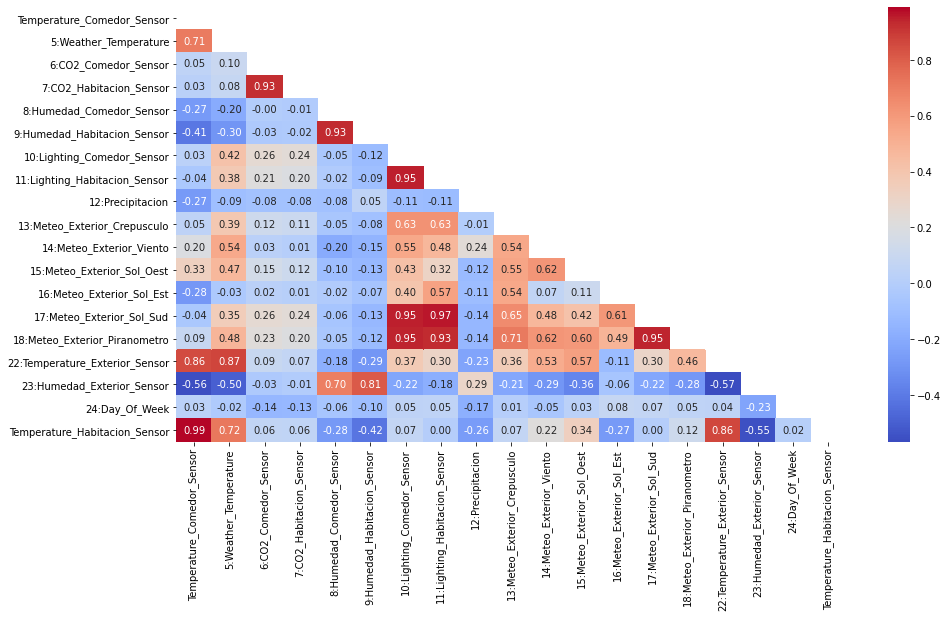

In [ ]:
import seaborn as sns

corr = df_etude.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 8))

sns.heatmap(corr,mask=mask, cmap='coolwarm',annot=True, fmt='.2f')

# Identification des variables les plus importantes par Random Forest

**1. Création des données X et Y**

In [ ]:
X = df_etude.iloc[:,0:-1]
X

,Temperature_Comedor_Sensor,5:Weather_Temperature,6:CO2_Comedor_Sensor,7:CO2_Habitacion_Sensor,8:Humedad_Comedor_Sensor,9:Humedad_Habitacion_Sensor,10:Lighting_Comedor_Sensor,11:Lighting_Habitacion_Sensor,12:Precipitacion,13:Meteo_Exterior_Crepusculo,14:Meteo_Exterior_Viento,15:Meteo_Exterior_Sol_Oest,16:Meteo_Exterior_Sol_Est,17:Meteo_Exterior_Sol_Sud,18:Meteo_Exterior_Piranometro,22:Temperature_Exterior_Sensor,23:Humedad_Exterior_Sensor,24:Day_Of_Week
0,18.187500,0.0000,216.559998,221.919998,39.912498,42.415001,81.665001,113.519997,0.0,623.359985,1.426250,9690.240234,12604.200195,95436.796875,758.880005,18.115000,48.375000,2.0
1,18.463301,6.8000,219.947006,220.363007,39.926701,42.245300,81.741302,113.605003,0.0,623.210999,1.592000,11022.000000,10787.200195,95436.796875,762.068970,18.414700,47.807999,2.0
2,18.767300,17.0000,219.403000,218.932999,39.771999,42.226700,81.424004,113.599998,0.0,622.656006,1.891330,13960.500000,9669.629883,95398.601562,766.250977,18.853300,47.431999,2.0
3,19.072701,18.0000,218.613007,217.044998,39.776001,42.098701,81.501297,113.344002,0.0,622.570984,1.828000,18511.199219,9648.129883,95360.296875,766.036987,19.290701,47.023998,2.0
4,19.372101,20.0000,217.714005,216.080002,39.775700,42.068600,81.465698,113.033997,0.0,622.400024,2.360710,26349.000000,9208.320312,95354.898438,762.742981,19.740000,45.474300,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759,21.152000,13.0000,190.539001,192.181000,41.312000,41.688000,11.442700,12.940000,0.0,392.602997,0.074667,0.000000,0.000000,0.000000,-3.434000,16.618000,49.296001,3.0
2760,21.041300,12.1333,190.421005,193.067001,41.317299,41.720001,11.686700,19.320000,0.0,613.119995,0.000000,465.920013,2716.669922,523.263977,3.852000,16.401300,50.037300,3.0
2761,20.934700,12.0000,190.432007,193.653000,41.333302,41.757301,19.538700,23.242701,0.0,613.802979,0.310667,3454.979980,16203.799805,3347.459961,26.830000,16.260700,50.058701,3.0
2762,20.856001,12.0000,191.531006,193.386993,41.309299,41.810699,20.985300,23.440001,0.0,615.403015,0.299333,6795.259766,38303.101562,7110.660156,66.949303,16.236700,49.840000,3.0


In [ ]:
Y = df_etude.iloc[:,-1:]
Y

,Temperature_Habitacion_Sensor
0,17.827499
1,18.120701
2,18.436701
3,18.751301
4,19.041401
...,...
2759,20.818701
2760,20.705299
2761,20.582701
2762,20.520000


**1. Choix du nombre d'arbres**

On commence par regarder comment évolue le score sur une 10ène d'essais avec un nombre d'arbres croissant :

In [ ]:
# Informations sur les données
n = 2764              # Nombre d'observations
p = 18                # Nombre de variables

n_arbres_max = 2000

n_arbres = np.linspace(50,n_arbres_max,10).astype(np.int32)
mtry = np.sqrt(p).astype(np.int32)
OOB_err = []

for i in n_arbres:
  print("#Arbres : %d" %i)
  clf = RandomForestRegressor(n_estimators=i, bootstrap=True, oob_score=True, max_samples = n, max_features = mtry, n_jobs=-1)
  clf.fit(X,tf.squeeze(np.asarray(Y),1))
  OOB_err.append(1 - clf.oob_score_)

#Arbres : 50
#Arbres : 266
#Arbres : 483
#Arbres : 700
#Arbres : 916
#Arbres : 1133
#Arbres : 1350
#Arbres : 1566
#Arbres : 1783
#Arbres : 2000


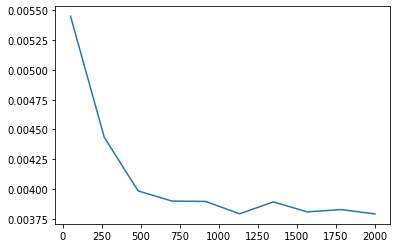

In [ ]:
plt.plot(n_arbres,OOB_err)

On choisir n_arbres = 2000 et on utilise m_try = 18

# Importance des variables - Pemière approche : Importance sans permutations

**1. Entrainement de la forêt**

In [ ]:
from sklearn.inspection import permutation_importance

# Informations sur les données
n = 2764             # Nombre d'observations
p = 18               # Nombre de variables
n_arbres = 2000
m_try = p

clf = RandomForestRegressor(n_estimators=n_arbres, bootstrap=True, oob_score=True, max_features=m_try, n_jobs=-1)
clf.fit(X,tf.squeeze(np.asarray(Y),1))

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=18, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=2000, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

**2. Affichage de l'importance des variables**

In [ ]:
col_sorted_by_importance=clf.feature_importances_.argsort()
feat_imp = pd.DataFrame({'cols':X.columns[col_sorted_by_importance],'imps':clf.feature_importances_[col_sorted_by_importance]})
feat_imp

,cols,imps
0,12:Precipitacion,0.000002
1,14:Meteo_Exterior_Viento,0.000340
2,18:Meteo_Exterior_Piranometro,0.000362
3,23:Humedad_Exterior_Sensor,0.000402
4,16:Meteo_Exterior_Sol_Est,0.000417
5,15:Meteo_Exterior_Sol_Oest,0.000426
6,10:Lighting_Comedor_Sensor,0.000484
7,8:Humedad_Comedor_Sensor,0.000498
8,13:Meteo_Exterior_Crepusculo,0.000649
9,11:Lighting_Habitacion_Sensor,0.000665


In [ ]:
!pip install plotly_express --upgrade -q

In [ ]:
import plotly_express as px
import plotly.offline as po

px.bar(feat_imp.sort_values(['imps'], ascending=False)[:30], x='cols', y='imps', labels={'cols':'column', 'imps':'feature importance'})

# Importance des variables - Deuxième approche : Méthode par permutations des importances

Permutation importance is a technique where we shuffle the values of a single column and run the model to see how the scores get affected. If the scores are affected greatly, then the feature is highly important to the model and if not, it does not add significant value to the model.

Let us see the feature importances for recall score on the test dataset.

In [ ]:
import random

def PermImportance(X, y, clf, metric, num_iterations=100):
    '''
    Calculates the permutation importance of features in a dataset.
    Inputs:
    X: dataframe with all the features
    y: array-like sequence of labels
    clf: sklearn classifier, already trained on training data
    num_iterations: no. of repetitive runs of the permutation
    Outputs:
    baseline: the baseline metric without any of the columns permutated
    scores: differences in baseline metric caused by permutation of each feature, dict in the format {feature:[diffs]}
    '''
    bar=progressbar.ProgressBar(max_value=len(X.columns))
    baseline_metric=clf.score(X,y)
    scores={c:[] for c in X.columns}
    for c in X.columns:
        X1=X.copy(deep=True)
        for _ in range(num_iterations):
            temp=X1[c].tolist()
            random.shuffle(temp)
            X1[c]=temp
            score = clf.score(X1,y)
            scores[c].append(baseline_metric-score)
        bar.update(X.columns.tolist().index(c))
    return baseline_metric, scores

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import progressbar

baseline, scores = PermImportance(X, tf.squeeze(np.asarray(Y),1), clf, recall_score, num_iterations=10)

 94% (17 of 18) |######################  | Elapsed Time: 0:02:00 ETA:   0:00:07

In [ ]:
percent_changes={c:[] for c in X.columns}
for c in scores:
    for i in range(len(scores[c])):
        percent_changes[c].append(scores[c][i]/baseline*100)

In [ ]:
pd.DataFrame.from_dict(percent_changes).melt().groupby(['variable']).mean().reset_index().sort_values(['value'], ascending=False)

,variable,value
17,Temperature_Comedor_Sensor,192.264162
14,7:CO2_Habitacion_Sensor,0.657906
16,9:Humedad_Habitacion_Sensor,0.396305
12,5:Weather_Temperature,0.247687
9,22:Temperature_Exterior_Sensor,0.229789
11,24:Day_Of_Week,0.210114
13,6:CO2_Comedor_Sensor,0.151230
3,13:Meteo_Exterior_Crepusculo,0.051992
7,17:Meteo_Exterior_Sol_Sud,0.049651
1,11:Lighting_Habitacion_Sensor,0.048503


In [ ]:
px.bar(
    pd.DataFrame.from_dict(percent_changes).melt().groupby(['variable']).mean().reset_index().sort_values(['value'], ascending=False),
    x='variable',y='value',labels={'variable':'column','value':'% change in recall'})

# Comparaison entre les deux méthodes

In [ ]:
# Calcul des écarts-types et des moyennes
scores_std = {}
scores_mean = {}
for element in scores:
  scores_std[element] = np.std(scores[element])
  scores_mean[element] = np.mean(scores[element])

df_perm = pd.DataFrame.from_dict([scores_std, scores_mean]).transpose()
df_perm = df_perm.rename(columns={0:"std",1:"mean"})
df_perm = df_perm.sort_values(by=['mean'],ascending=False)
df_perm

,std,mean
Temperature_Comedor_Sensor,3.126019e-02,1.920870e+00
7:CO2_Habitacion_Sensor,2.521359e-04,6.572996e-03
9:Humedad_Habitacion_Sensor,4.439854e-04,3.959396e-03
5:Weather_Temperature,1.909467e-04,2.474586e-03
22:Temperature_Exterior_Sensor,1.110536e-04,2.295771e-03
24:Day_Of_Week,2.797046e-04,2.099202e-03
6:CO2_Comedor_Sensor,1.116770e-04,1.510904e-03
13:Meteo_Exterior_Crepusculo,1.674762e-05,5.194403e-04
17:Meteo_Exterior_Sol_Sud,4.268942e-05,4.960481e-04
11:Lighting_Habitacion_Sensor,1.839969e-05,4.845845e-04


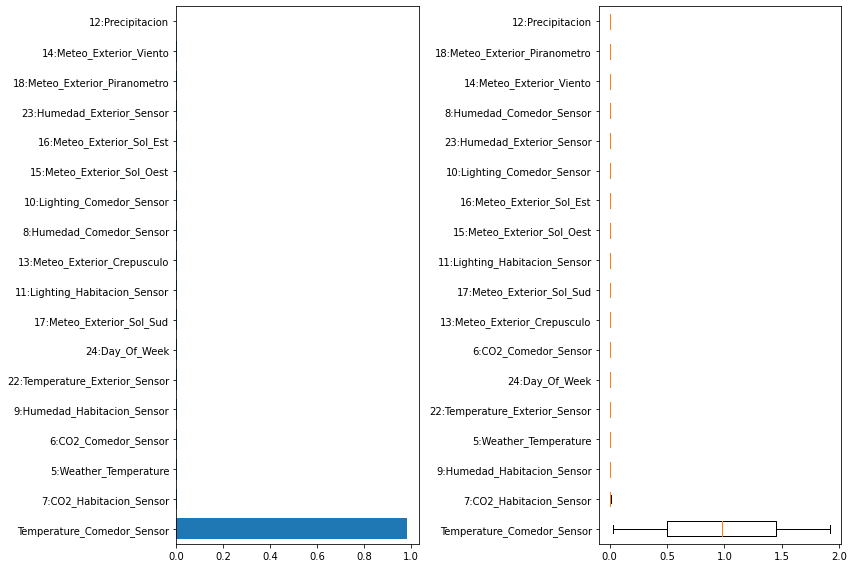

In [ ]:
feature_perm = df_perm
feature_imp = feat_imp.sort_values(['imps'],ascending=False)
feature_imp = feature_imp

tree_indices = np.arange(0, len(feature_imp)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

ax1.barh(tree_indices,feature_imp['imps'].values, height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(feature_imp['cols'].values)
ax1.set_ylim((0, len(feature_imp)))

ax2.boxplot(feature_perm, vert=False,labels=feature_perm.index.values)
fig.tight_layout()
plt.show()

https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/SelectVariablesSML.png?raw=true

# Sélection des variables par méthode RFE

In [ ]:
from sklearn.feature_selection import RFE

# Informations sur les données
n = 2764             # Nombre d'observations
p = 18               # Nombre de variables
n_arbres = 2000
m_try = "auto"

clf = RandomForestRegressor(n_estimators=n_arbres, bootstrap=True, oob_score=True, max_features=m_try, n_jobs=-1)
rfe = RFE(estimator=clf, n_features_to_select=3, step=1, verbose=1)
rfe.fit(X, tf.squeeze(np.asarray(Y),1))

Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.


RFE(estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                    criterion='mse', max_depth=None,
                                    max_features='auto', max_leaf_nodes=None,
                                    max_samples=None, min_impurity_decrease=0.0,
                                    min_impurity_split=None, min_samples_leaf=1,
                                    min_samples_split=2,
                                    min_weight_fraction_leaf=0.0,
                                    n_estimators=2000, n_jobs=-1,
                                    oob_score=True, random_state=None,
                                    verbose=0, warm_start=False),
    n_features_to_select=3, step=1, verbose=1)

In [ ]:
rfe.ranking_

array([ 1,  2,  4,  1, 10,  3,  9,  7, 16,  8, 15, 11, 12,  5, 14,  1, 13,
        6])

array([ 1,  2,  4,  1, 10,  3,  9,  7, 16,  8, 15, 11, 12,  5, 14,  1, 13,
        6])

In [ ]:
rank = np.asarray([ 1,  2,  4,  1, 10,  3,  9,  7, 16,  8, 15, 11, 12,  5, 14,  1, 13,6])
X.iloc[:,rank-1]

,Temperature_Comedor_Sensor,5:Weather_Temperature,7:CO2_Habitacion_Sensor,Temperature_Comedor_Sensor,13:Meteo_Exterior_Crepusculo,6:CO2_Comedor_Sensor,12:Precipitacion,10:Lighting_Comedor_Sensor,22:Temperature_Exterior_Sensor,11:Lighting_Habitacion_Sensor,18:Meteo_Exterior_Piranometro,14:Meteo_Exterior_Viento,15:Meteo_Exterior_Sol_Oest,8:Humedad_Comedor_Sensor,17:Meteo_Exterior_Sol_Sud,Temperature_Comedor_Sensor,16:Meteo_Exterior_Sol_Est,9:Humedad_Habitacion_Sensor
0,18.187500,0.0000,221.919998,18.187500,623.359985,216.559998,0.0,81.665001,18.115000,113.519997,758.880005,1.426250,9690.240234,39.912498,95436.796875,18.187500,12604.200195,42.415001
1,18.463301,6.8000,220.363007,18.463301,623.210999,219.947006,0.0,81.741302,18.414700,113.605003,762.068970,1.592000,11022.000000,39.926701,95436.796875,18.463301,10787.200195,42.245300
2,18.767300,17.0000,218.932999,18.767300,622.656006,219.403000,0.0,81.424004,18.853300,113.599998,766.250977,1.891330,13960.500000,39.771999,95398.601562,18.767300,9669.629883,42.226700
3,19.072701,18.0000,217.044998,19.072701,622.570984,218.613007,0.0,81.501297,19.290701,113.344002,766.036987,1.828000,18511.199219,39.776001,95360.296875,19.072701,9648.129883,42.098701
4,19.372101,20.0000,216.080002,19.372101,622.400024,217.714005,0.0,81.465698,19.740000,113.033997,762.742981,2.360710,26349.000000,39.775700,95354.898438,19.372101,9208.320312,42.068600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759,21.152000,13.0000,192.181000,21.152000,392.602997,190.539001,0.0,11.442700,16.618000,12.940000,-3.434000,0.074667,0.000000,41.312000,0.000000,21.152000,0.000000,41.688000
2760,21.041300,12.1333,193.067001,21.041300,613.119995,190.421005,0.0,11.686700,16.401300,19.320000,3.852000,0.000000,465.920013,41.317299,523.263977,21.041300,2716.669922,41.720001
2761,20.934700,12.0000,193.653000,20.934700,613.802979,190.432007,0.0,19.538700,16.260700,23.242701,26.830000,0.310667,3454.979980,41.333302,3347.459961,20.934700,16203.799805,41.757301
2762,20.856001,12.0000,193.386993,20.856001,615.403015,191.531006,0.0,20.985300,16.236700,23.440001,66.949303,0.299333,6795.259766,41.309299,7110.660156,20.856001,38303.101562,41.810699


# Sélection des variables par méthode RFE-CV

In [ ]:
from sklearn.feature_selection import RFECV

# Informations sur les données
n = 2764             # Nombre d'observations
p = 18               # Nombre de variables
n_arbres = 2000
m_try = p
min_features_to_select = 3

clf = RandomForestRegressor(n_estimators=n_arbres, bootstrap=True, oob_score=True, max_features="auto", n_jobs=-1)
rfecv = RFECV(estimator=clf, step=1, cv=5, scoring='neg_mean_absolute_error',min_features_to_select=min_features_to_select, verbose=1)
rfecv.fit(X, tf.squeeze(np.asarray(Y),1))

Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fi

RFECV(cv=5,
      estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                      criterion='mse', max_depth=None,
                                      max_features='auto', max_leaf_nodes=None,
                                      max_samples=None,
                                      min_impurity_decrease=0.0,
                                      min_impurity_split=None,
                                      min_samples_leaf=1, min_samples_split=2,
                                      min_weight_fraction_leaf=0.0,
                                      n_estimators=2000, n_jobs=-1,
                                      oob_score=True, random_state=None,
                                      verbose=0, warm_start=False),
      min_features_to_select=3, n_jobs=None, scoring='neg_mean_absolute_error',
      step=1, verbose=1)

Optimal number of features : 13


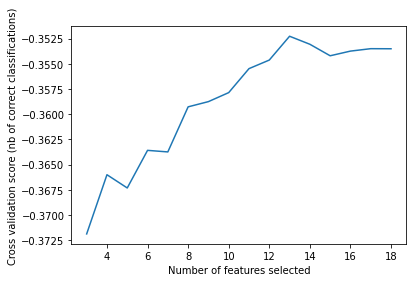

In [ ]:
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()

In [ ]:
rfecv.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 5, 1, 2, 1, 4, 1, 3, 1])

array([1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 5, 1, 2, 1, 4, 1, 3, 1])

In [ ]:
pd.DataFrame(X[X.columns[0]])

,Temperature_Comedor_Sensor
0,18.187500
1,18.463301
2,18.767300
3,19.072701
4,19.372101
...,...
2759,21.152000
2760,21.041300
2761,20.934700
2762,20.856001


In [ ]:
X.columns[0]

'Temperature_Comedor_Sensor'

In [ ]:
selected = np.asarray([1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 5, 1, 2, 1, 4, 1, 3, 1])
df_selected = pd.DataFrame()

for i in range(len(X.columns)):
  if selected[i] == 1:
    df_selected[X.columns[i]] = X[X.columns[i]]

df_selected

,Temperature_Comedor_Sensor,5:Weather_Temperature,6:CO2_Comedor_Sensor,7:CO2_Habitacion_Sensor,8:Humedad_Comedor_Sensor,9:Humedad_Habitacion_Sensor,10:Lighting_Comedor_Sensor,11:Lighting_Habitacion_Sensor,13:Meteo_Exterior_Crepusculo,15:Meteo_Exterior_Sol_Oest,17:Meteo_Exterior_Sol_Sud,22:Temperature_Exterior_Sensor,24:Day_Of_Week
0,18.187500,0.0000,216.559998,221.919998,39.912498,42.415001,81.665001,113.519997,623.359985,9690.240234,95436.796875,18.115000,2.0
1,18.463301,6.8000,219.947006,220.363007,39.926701,42.245300,81.741302,113.605003,623.210999,11022.000000,95436.796875,18.414700,2.0
2,18.767300,17.0000,219.403000,218.932999,39.771999,42.226700,81.424004,113.599998,622.656006,13960.500000,95398.601562,18.853300,2.0
3,19.072701,18.0000,218.613007,217.044998,39.776001,42.098701,81.501297,113.344002,622.570984,18511.199219,95360.296875,19.290701,2.0
4,19.372101,20.0000,217.714005,216.080002,39.775700,42.068600,81.465698,113.033997,622.400024,26349.000000,95354.898438,19.740000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759,21.152000,13.0000,190.539001,192.181000,41.312000,41.688000,11.442700,12.940000,392.602997,0.000000,0.000000,16.618000,3.0
2760,21.041300,12.1333,190.421005,193.067001,41.317299,41.720001,11.686700,19.320000,613.119995,465.920013,523.263977,16.401300,3.0
2761,20.934700,12.0000,190.432007,193.653000,41.333302,41.757301,19.538700,23.242701,613.802979,3454.979980,3347.459961,16.260700,3.0
2762,20.856001,12.0000,191.531006,193.386993,41.309299,41.810699,20.985300,23.440001,615.403015,6795.259766,7110.660156,16.236700,3.0


Exportation du dataframe :

In [ ]:
df_selected.insert(len(df_selected.columns),"Temperature_Habitacion_Sensor",cible)


In [ ]:
df_selected

,Temperature_Comedor_Sensor,5:Weather_Temperature,6:CO2_Comedor_Sensor,7:CO2_Habitacion_Sensor,8:Humedad_Comedor_Sensor,9:Humedad_Habitacion_Sensor,10:Lighting_Comedor_Sensor,11:Lighting_Habitacion_Sensor,13:Meteo_Exterior_Crepusculo,15:Meteo_Exterior_Sol_Oest,17:Meteo_Exterior_Sol_Sud,22:Temperature_Exterior_Sensor,24:Day_Of_Week,Temperature_Habitacion_Sensor
0,18.187500,0.0000,216.559998,221.919998,39.912498,42.415001,81.665001,113.519997,623.359985,9690.240234,95436.796875,18.115000,2.0,17.8275
1,18.463301,6.8000,219.947006,220.363007,39.926701,42.245300,81.741302,113.605003,623.210999,11022.000000,95436.796875,18.414700,2.0,18.1207
2,18.767300,17.0000,219.403000,218.932999,39.771999,42.226700,81.424004,113.599998,622.656006,13960.500000,95398.601562,18.853300,2.0,18.4367
3,19.072701,18.0000,218.613007,217.044998,39.776001,42.098701,81.501297,113.344002,622.570984,18511.199219,95360.296875,19.290701,2.0,18.7513
4,19.372101,20.0000,217.714005,216.080002,39.775700,42.068600,81.465698,113.033997,622.400024,26349.000000,95354.898438,19.740000,2.0,19.0414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759,21.152000,13.0000,190.539001,192.181000,41.312000,41.688000,11.442700,12.940000,392.602997,0.000000,0.000000,16.618000,3.0,20.8187
2760,21.041300,12.1333,190.421005,193.067001,41.317299,41.720001,11.686700,19.320000,613.119995,465.920013,523.263977,16.401300,3.0,20.7053
2761,20.934700,12.0000,190.432007,193.653000,41.333302,41.757301,19.538700,23.242701,613.802979,3454.979980,3347.459961,16.260700,3.0,20.5827
2762,20.856001,12.0000,191.531006,193.386993,41.309299,41.810699,20.985300,23.440001,615.403015,6795.259766,7110.660156,16.236700,3.0,20.5200


In [ ]:
from google.colab import files

df_selected.to_csv("SML2010_RFE-CV.csv")
files.download("SML2010_RFE-CV.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Extraction des données pour VSURF

**1. Extraction des données**

In [ ]:
X = df_etude.iloc[:,:-1]
X

,Temperature_Comedor_Sensor,5:Weather_Temperature,6:CO2_Comedor_Sensor,7:CO2_Habitacion_Sensor,8:Humedad_Comedor_Sensor,9:Humedad_Habitacion_Sensor,10:Lighting_Comedor_Sensor,11:Lighting_Habitacion_Sensor,12:Precipitacion,13:Meteo_Exterior_Crepusculo,14:Meteo_Exterior_Viento,15:Meteo_Exterior_Sol_Oest,16:Meteo_Exterior_Sol_Est,17:Meteo_Exterior_Sol_Sud,18:Meteo_Exterior_Piranometro,22:Temperature_Exterior_Sensor,23:Humedad_Exterior_Sensor,24:Day_Of_Week
0,18.187500,0.0000,216.559998,221.919998,39.912498,42.415001,81.665001,113.519997,0.0,623.359985,1.426250,9690.240234,12604.200195,95436.796875,758.880005,18.115000,48.375000,2.0
1,18.463301,6.8000,219.947006,220.363007,39.926701,42.245300,81.741302,113.605003,0.0,623.210999,1.592000,11022.000000,10787.200195,95436.796875,762.068970,18.414700,47.807999,2.0
2,18.767300,17.0000,219.403000,218.932999,39.771999,42.226700,81.424004,113.599998,0.0,622.656006,1.891330,13960.500000,9669.629883,95398.601562,766.250977,18.853300,47.431999,2.0
3,19.072701,18.0000,218.613007,217.044998,39.776001,42.098701,81.501297,113.344002,0.0,622.570984,1.828000,18511.199219,9648.129883,95360.296875,766.036987,19.290701,47.023998,2.0
4,19.372101,20.0000,217.714005,216.080002,39.775700,42.068600,81.465698,113.033997,0.0,622.400024,2.360710,26349.000000,9208.320312,95354.898438,762.742981,19.740000,45.474300,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759,21.152000,13.0000,190.539001,192.181000,41.312000,41.688000,11.442700,12.940000,0.0,392.602997,0.074667,0.000000,0.000000,0.000000,-3.434000,16.618000,49.296001,3.0
2760,21.041300,12.1333,190.421005,193.067001,41.317299,41.720001,11.686700,19.320000,0.0,613.119995,0.000000,465.920013,2716.669922,523.263977,3.852000,16.401300,50.037300,3.0
2761,20.934700,12.0000,190.432007,193.653000,41.333302,41.757301,19.538700,23.242701,0.0,613.802979,0.310667,3454.979980,16203.799805,3347.459961,26.830000,16.260700,50.058701,3.0
2762,20.856001,12.0000,191.531006,193.386993,41.309299,41.810699,20.985300,23.440001,0.0,615.403015,0.299333,6795.259766,38303.101562,7110.660156,66.949303,16.236700,49.840000,3.0


In [ ]:
Y = df_etude.iloc[:,-1:]
Y

,Temperature_Habitacion_Sensor
0,17.827499
1,18.120701
2,18.436701
3,18.751301
4,19.041401
...,...
2759,20.818701
2760,20.705299
2761,20.582701
2762,20.520000


In [ ]:
from google.colab import files

X.to_csv("X.csv")
Y.to_csv("Y.csv")

files.download("X.csv")
files.download("Y.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**2. Résultats**

Résultats :

> print(rsult$varselect.thres)  
 [1]  1  4  2  6 16 18  3 12 10  5 17  8 13  7 15 11 14

> print(rsult$varselect.interp)  
 [1]  1  4  2  6 16 18  3 12 10  5 17

> print(rsult$varselect.pred)  
[1] 1 4 2 6

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/VSURF_SML.png?raw=true' width=800>

**3. Création du dataframe**

In [ ]:
selected_pred = np.asarray([1,4,2,6])
selected_VSURF_pred = pd.DataFrame()

for i in range(len(selected_pred)):
    selected_VSURF_pred[X.columns[selected_pred[i]-1]] = X[X.columns[selected_pred[i]-1]]

selected_VSURF_pred['Temperature_Habitacion_Sensor'] = Y['Temperature_Habitacion_Sensor']
selected_VSURF_pred

,Temperature_Comedor_Sensor,7:CO2_Habitacion_Sensor,5:Weather_Temperature,9:Humedad_Habitacion_Sensor,Temperature_Habitacion_Sensor
0,18.187500,221.919998,0.0000,42.415001,17.827499
1,18.463301,220.363007,6.8000,42.245300,18.120701
2,18.767300,218.932999,17.0000,42.226700,18.436701
3,19.072701,217.044998,18.0000,42.098701,18.751301
4,19.372101,216.080002,20.0000,42.068600,19.041401
...,...,...,...,...,...
2759,21.152000,192.181000,13.0000,41.688000,20.818701
2760,21.041300,193.067001,12.1333,41.720001,20.705299
2761,20.934700,193.653000,12.0000,41.757301,20.582701
2762,20.856001,193.386993,12.0000,41.810699,20.520000


In [ ]:
from google.colab import files

selected_VSURF_pred.to_csv("SMLselected_VSURF_pred.csv")

files.download("SMLselected_VSURF_pred.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>